In [1]:
import numpy as np

import torch 
from torchvision import datasets, transforms

from pyhessian import hessian # Hessian computation

from utils import * # get the dataset

from density_plot import get_esd_plot # ESD plot
from pytorchcv.model_provider import get_model as ptcv_get_model # model

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# get the model 
model = ptcv_get_model("resnet20_cifar10", pretrained=True)
# change the model to eval mode to disable running stats upate
model.eval()

# create loss function
criterion = torch.nn.CrossEntropyLoss()

# get dataset 
train_loader, test_loader = getData()

# for illustrate, we only use one batch to do the tutorial
for inputs, targets in train_loader:
    break

# we use cuda to make the computation fast
# model = model.cuda()
# inputs, targets = inputs.cuda(), targets.cuda()

Files already downloaded and verified


In [3]:
# create the hessian computation module
hessian_comp = hessian(model, criterion, data=(inputs, targets), cuda=False) # cuda=True

/Users/geventh/miniforge3/lib/python3.10/site-packages/torch/autograd/__init__.py:251: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/engine.cpp:1176.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [4]:
# Now let's compute the top eigenvalue. This only takes a few seconds.
top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues()
print("The top Hessian eigenvalue of this model is %.4f"%top_eigenvalues[-1])

The top Hessian eigenvalue of this model is 151.6553


In [5]:
# Now let's compute the top 2 eigenavlues and eigenvectors of the Hessian
top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues(top_n=2)
print("The top two eigenvalues of this model are: %.4f %.4f"% (top_eigenvalues[-1],top_eigenvalues[-2]))

The top two eigenvalues of this model are: 127.5958 151.6504


## Loss Landscape by going in top hessian eigenvector direction in parameter space

Text(0.5, 1.0, 'Loss landscape perturbed based on top Hessian eigenvector')

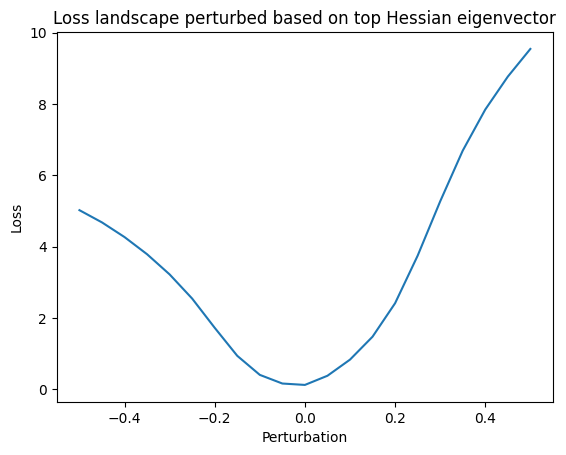

In [6]:
# get the top eigenvector
top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues()

# This is a simple function, that will allow us to perturb the model paramters and get the result
def get_params(model_orig,  model_perb, direction, alpha):
    for m_orig, m_perb, d in zip(model_orig.parameters(), model_perb.parameters(), direction):
        m_perb.data = m_orig.data + alpha * d
    return model_perb

# lambda is a small scalar that we use to perturb the model parameters along the eigenvectors 
lams = np.linspace(-0.5, 0.5, 21).astype(np.float32)

loss_list = []

# create a copy of the model
model_perb = ptcv_get_model("resnet20_cifar10", pretrained=True)
model_perb.eval()
# model_perb = model_perb.cuda()

for lam in lams:
    model_perb = get_params(model, model_perb, top_eigenvector[0], lam)
    loss_list.append(criterion(model_perb(inputs), targets).item())

plt.plot(lams, loss_list)
plt.ylabel('Loss')
plt.xlabel('Perturbation')
plt.title('Loss landscape perturbed based on top Hessian eigenvector')

## Loss Landscape by going in gradient direction in parameter space

Text(0.5, 1.0, 'Loss landscape perturbed based on gradient direction')

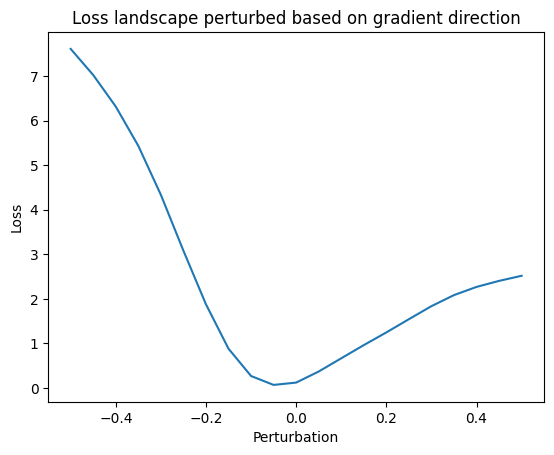

In [7]:
from pyhessian.utils import normalization


# used to perturb your model 
lams = np.linspace(-0.5, 0.5, 21).astype(np.float32)

loss_list = []

# create a copy of the model
model_perb = ptcv_get_model("resnet20_cifar10", pretrained=True)
model_perb.eval()
# model_perb = model_perb.cuda()

# generate gradient vector to do the loss plot
loss = criterion(model_perb(inputs), targets)
loss.backward()

v = [p.grad.data for p in model_perb.parameters()]
v = normalization(v)
model_perb.zero_grad()


for lam in lams: 
    model_perb = get_params(model, model_perb, v, lam)
    loss_list.append(criterion(model_perb(inputs), targets).item())

plt.plot(lams, loss_list)
plt.ylabel('Loss')
plt.xlabel('Perturbation')
plt.title('Loss landscape perturbed based on gradient direction')

## Loss Landscape by going in random direction in parameter space

Text(0.5, 1.0, 'Loss landscape perturbed based on a random direction')

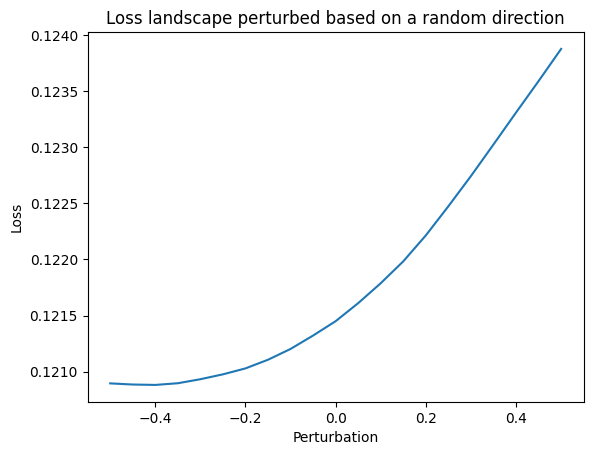

In [8]:

from pyhessian.utils import normalization

# generate random vector to do the loss plot

v = [torch.randn_like(p) for p in model.parameters()]
v = normalization(v)


# used to perturb your model 
lams = np.linspace(-0.5, 0.5, 21).astype(np.float32)

loss_list = []

# create a copy of the model
model_perb = ptcv_get_model("resnet20_cifar10", pretrained=True)
model_perb.eval()
# model_perb = model_perb.cuda()

for lam in lams: 
    model_perb = get_params(model, model_perb, v, lam)
    loss_list.append(criterion(model_perb(inputs), targets).item())

plt.plot(lams, loss_list)
plt.ylabel('Loss')
plt.xlabel('Perturbation')
plt.title('Loss landscape perturbed based on a random direction')

## Trace Computation

In [9]:
trace = hessian_comp.trace()
print("The trace of this model is: %.4f"%(np.mean(trace)))

The trace of this model is: 1028.7773


### The ESD plot is very interesting and shows that a lot of the eigenvalues of the Hessian are close to zero. This means that a lot of the directions along the loss landscape is almost flat. We expect this based on the loss landscape that we got above when we used a random direction. Another interesting observation is that there are several large Hessian outliers. The other very interesting finding, is that there are a lot of directions with slight negative curvature. This means that we still have not converged to a perfect local minimum that satisfies first and second order optimality conditions. - PyHessian Tutorial

In [ ]:
# File ~/miniforge3/lib/python3.10/site-packages/torch/_linalg_utils.py:153, in eig(self, eigenvectors, e, v)
#     150 def eig(
#     151     self: Tensor, eigenvectors: bool = False, *, e=None, v=None
#     152 ) -> Tuple[Tensor, Tensor]:
# --> 153     raise RuntimeError(
#     154         "This function was deprecated since version 1.9 and is now removed. "
#     155         "`torch.linalg.eig` returns complex tensors of dtype `cfloat` or `cdouble` rather than real tensors "
#     156         "mimicking complex tensors.\n\n"
#     157         "L, _ = torch.eig(A) "
#     158         "should be replaced with:\n"
#     159         "L_complex = torch.linalg.eigvals(A)\n\n"
#     160         "and\n\n"
# ...

# and

# L, V = torch.eig(A, eigenvectors=True) should be replaced with:
# L_complex, V_complex = torch.linalg.eig(A)

density_eigen, density_weight = hessian_comp.density()
get_esd_plot(density_eigen, density_weight)

In [ ]:
# !pipreqsnb . 